<a href="https://colab.research.google.com/github/Jeditem/VKCup_2020/blob/master/VKCup_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import itertools
import numpy as np
import pandas as pd
import pandas_profiling as pd_prof
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import mean_squared_error
from scipy.stats import lognorm, norm

from lightgbm import LGBMRegressor, plot_importance
from xgboost import XGBRegressor
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
users_df = pd.read_csv(r'/content/gdrive/My Drive/VKCup/users.tsv', sep='\t')
history_df = pd.read_csv(r'/content/gdrive/My Drive/VKCup/history.tsv', sep='\t')
validate_df = pd.read_csv(r'/content/gdrive/My Drive/VKCup/validate.tsv', sep='\t')
answers_df = pd.read_csv(r'/content/gdrive/My Drive/VKCup/validate_answers.tsv', sep='\t')

# Data preparation

In [0]:
X = validate_df.copy()
Y = answers_df.copy()
users_prep = users_df.copy()
history_prep = history_df.copy()
# объединим на время с ответами, чтобы было удобнее сортировать и обрабатывать
X = X.join(Y)

In [0]:
# Сначала сконвертим колонки с площадками и юзерами в листы и возьмем их размеры
X['user_ids'] = X['user_ids'].astype(str).str.split(',')
X['audience_size'] = X['user_ids'].str.len()
X['publishers'] = X['publishers'].astype(str).str.split(',')
X['publishers_amount'] = X['publishers'].str.len()
# Здесь де вычислим продолжительность рекламы
X['ads_duration'] = X['hour_end'] - X['hour_start']

In [0]:
# вычисляем параметры распределения ставок
# вычисляем среднюю цену юзера по его просмотрам
history_for_param = history_prep[(history_prep['cpm'] <=1000)]
param_total=lognorm.fit(history_for_param['cpm'], floc=0)
param_total
users_costs = history_for_param.groupby('user_id')['cpm'].mean()
users_df = users_df.join(users_costs).fillna(0.0)

In [0]:
# По параметрам распределения оценим вероятность, что хоть кто-то за такую цену хоть раз увидит это все
X['proba_one'] = X.apply(lambda row: lognorm.cdf(row['cpm'], *param_total), axis=1)

In [0]:
# теперь вычислим для каждой ставки, среднюю стоимость товарищей, на которых она целится, и разницу
# UPD практика показала, что можно даже не считать вероятность, модельке хватает разницы
def calculate_mean_cpm_by_users (users_list):
    total_cpm = []
    for user in users_list:
        curr_user_cost = users_df.iloc[[int(user)]]['cpm']
        total_cpm.append(curr_user_cost.values[0])
    return np.mean(total_cpm)

In [9]:
%%time
X['mean_cost'] = X.apply(lambda row: calculate_mean_cpm_by_users(row['user_ids']), axis=1)
X['discrepancy'] = X['mean_cost'] - X['cpm']

CPU times: user 7min 57s, sys: 103 ms, total: 7min 57s
Wall time: 7min 57s


In [0]:
# добавим сюда относительную разницу
X['relative_dif'] = X['mean_cost'].div(X['cpm'])

In [0]:
# сделаем то же самое для популярности юзера (сколько он в принципе посмотрел объявлений)
def calculate_mean_users_popul(users_list):
    total_popularity = []
    for user in users_list:
        try:
            total_popularity.append(users_popul_count[int(user)])
        except KeyError:
            total_popularity.append(0)
    return np.mean(total_popularity)

In [41]:
%%time
users_popul_count = history_df.groupby('user_id').count()['cpm']
users_popul_count.fillna(0)
X['mean_popularity'] = X.apply(lambda row: calculate_mean_users_popul(row['user_ids']), axis=1)

CPU times: user 10.9 s, sys: 45 ms, total: 10.9 s
Wall time: 10.9 s


In [42]:
X.head()

,cpm,hour_start,hour_end,publishers,audience_size,user_ids,at_least_one,at_least_two,at_least_three,publishers_amount,ads_duration,proba_one,mean_cost,discrepancy,relative_dif,mean_popularity
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",0.0430,0.0152,0.0073,2,95,0.788306,201.954843,-18.045157,0.917977,40.567156
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",0.0130,0.0000,0.0000,2,6,0.885477,160.744132,-151.255868,0.515206,128.990580
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",0.0878,0.0135,0.0000,6,20,0.302258,184.204108,114.204108,2.631487,43.977477
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",0.2295,0.1295,0.0727,2,82,0.816137,204.438568,-35.561432,0.851827,38.665909
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",0.3963,0.2785,0.2270,4,238,0.841761,219.125446,-42.874554,0.836357,35.524390


# Model validation

In [0]:
# metric
def get_smoothed_log_mape_column_value(responses_column, answers_column, epsilon):
    return np.abs(np.log(
        (responses_column + epsilon)
        / (answers_column + epsilon)
    )).mean()

def get_smoothed_mean_log_accuracy_ratio(answers, responses, epsilon=0.005):
    # sns.jointplot(responses.at_least_three, answers.at_least_three)
    log_accuracy_ratio = np.array(
        [
            get_smoothed_log_mape_column_value(responses.at_least_one, answers.at_least_one, epsilon),
            get_smoothed_log_mape_column_value(responses.at_least_two, answers.at_least_two, epsilon),
            get_smoothed_log_mape_column_value(responses.at_least_three, answers.at_least_three, epsilon),
        ]
    )
    log_accuracy_ratio_mean = log_accuracy_ratio.mean()
    # print(f'Log accuracy ratio: {log_accuracy_ratio}')
    # print(np.min(responses.at_least_three))
    percentage_error = 100 * (np.exp(log_accuracy_ratio_mean) - 1)

    return percentage_error.round(
        decimals=2
    )

In [0]:
def remove_neg(value):
    if value < 0.0:
        return 0.0
    else:
        return value

так как пока все фичи слабо зависят от времени (ну, кроме часа начала и часа конца), то можно не особо боясь заглянуть в будущее валидировать обычной кросс-валидацией

In [0]:
def standart_cross_validation(X, Y, model, n_folds=20):
    score_list = []
    for i in np.arange(0,n_folds):
        X_train, X_holdout, y_train, y_holdout = train_test_split(X, Y, test_size=0.3,random_state=i)
        model.fit(X_train, y_train)
        results = model.predict(X_holdout)
        result_df = pd.DataFrame(results, columns=['at_least_one','at_least_two','at_least_three'])
        score = get_smoothed_mean_log_accuracy_ratio(y_holdout, result_df)
        score_list.append(score)
    print(f'{np.mean(score_list)} ± {np.std(score_list)}')
    return score_list

In [0]:
 def multilabel_model_cross_validation(X, Y, model, n_folds=20):
    score_list = []
    for i in np.arange(0,n_folds):
        X_train, X_holdout, y_train, y_holdout = train_test_split(X, Y, test_size=0.3,random_state=i)
        # validate_test['log_least_one'] = np.log(validate_test['norm_least_one']+0.005)
        model.fit(X_train, np.log(y_train['at_least_one'] + 0.1))
        results1 = model.predict(X_holdout).reshape(len(y_holdout), 1)
        results1 = np.exp(results1) - 0.1
        model.fit(X_train, np.log(y_train['at_least_two'] + 0.1))
        results2 = model.predict(X_holdout).reshape(len(y_holdout), 1)
        results2 = np.exp(results2) - 0.1
        model.fit(X_train, np.log(y_train['at_least_three'] + 0.1))
        results3 = model.predict(X_holdout).reshape(len(y_holdout), 1)
        results3 = np.exp(results3) - 0.1
        # remove negative elements
        # results3 = np.array(list(map(remove_neg, results3)))
        # print(results3.shape)
        results = np.concatenate((results1, results2, results3), axis=1)
        result_df = pd.DataFrame(results, columns=['at_least_one','at_least_two','at_least_three'])
        score = get_smoothed_mean_log_accuracy_ratio(y_holdout, result_df)
        score_list.append(score)
    print(f'{np.mean(score_list)} ± {np.std(score_list)}')
    return score_list

In [0]:
# Fancy function to plot GridSearch results
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=12)
    ax.grid('on')
    fig = plt.gcf()
    fig.set_size_inches(20, 10)

# Calling Method 
# plot_grid_search(pipe_grid.cv_results_, n_estimators, max_features, 'N Estimators', 'Max Features')

In [0]:
# param search
# Works only for 2d search grid!!!
def custom_search(X, Y, model, param_dict):
    scores_matrix = np.zeros((len(list(param_name.values())[0]), len(list(param_name.values())[1])))
    size = scores_matrix.size
    n = 1
    for i, first_param in enumerate(list(param_name.values())[0]):
        for j, second_param in enumerate(list(param_name.values())[1]):
            curr_params = {list(param_name.keys())[0]: first_param, list(param_name.keys())[1]: second_param}
            # print(f'Current parameters: {curr_params}')
            print(f'Step {n}/{size}')
            model = model.set_params(**curr_params)
            # print(curr_model)
            scores_matrix[i,j] = np.mean(multilabel_model_cross_validation(X, Y, model))
            n += 1
    return scores_matrix

# Baseline

Бейзлайн здесь хитрый - все доли выставляются в нули. На LB идет значение 432,9, при валидации на тестовых данных получаем 448,86 - от них и будем отталкиваться при оценке наших моделей

In [0]:
base_results = np.zeros((1008, 3))
base_result_df = pd.DataFrame(base_results, columns=['at_least_one','at_least_two','at_least_three'])

In [0]:
get_smoothed_mean_log_accuracy_ratio(base_result_df, Y)

445.86

# Linear regression

In [0]:
lin_model = LinearRegression()

In [0]:
X_lin = X.copy()
X_lin = X_lin.drop(columns=['user_ids','publishers', 'at_least_one', 'at_least_two', 'at_least_three'])
# X_lin = X_lin[['cpm', 'ads_duration','proba_discrepancy']]

In [45]:
X_lin

,cpm,hour_start,hour_end,audience_size,publishers_amount,ads_duration,proba_one,mean_cost,discrepancy,relative_dif,mean_popularity
0,220.0,1058,1153,1906,2,95,0.788306,201.954843,-18.045157,0.917977,40.567156
1,312.0,1295,1301,1380,2,6,0.885477,160.744132,-151.255868,0.515206,128.990580
2,70.0,1229,1249,888,6,20,0.302258,184.204108,114.204108,2.631487,43.977477
3,240.0,1295,1377,440,2,82,0.816137,204.438568,-35.561432,0.851827,38.665909
4,262.0,752,990,1476,4,238,0.841761,219.125446,-42.874554,0.836357,35.524390
...,...,...,...,...,...,...,...,...,...,...,...
1003,127.0,1095,1154,368,5,59,0.566687,192.748666,65.748666,1.517706,37.201087
1004,90.0,1052,1056,484,2,4,0.409605,187.152288,97.152288,2.079470,41.793388
1005,122.0,1058,1063,704,2,5,0.548431,164.052075,42.052075,1.344689,115.884943
1006,138.0,932,1169,1210,3,237,0.603951,195.746255,57.746255,1.418451,35.154545


In [46]:
standart_cross_validation(X_lin, Y, lin_model)

417.642 ± 53.2332833479206


[320.56,
 371.98,
 374.83,
 386.84,
 409.03,
 485.86,
 401.36,
 388.44,
 536.33,
 473.09,
 429.19,
 375.02,
 454.77,
 378.17,
 429.21,
 435.22,
 526.87,
 382.09,
 397.05,
 396.93]

# LGBM

тут в процессе выяснилось, что изрядный вклад в ошибку вносит доля из минимум трех пользователей, потому что она часто уходит в минус. Думаю, если избавиться от этой проблемы, станет лучше

1) в тупую занулять не помогло(

2) возьмем логарифмы от таргетов и попробуем предсказывать их

In [0]:
param_dict = {'learning_rate': 0.05, 'n_estimators': 30, 'reg_alpha': 1.4}
# param_dict = {'learning_rate': 0.06}

In [0]:
lgbm_model = LGBMRegressor(**param_dict)
# lgbm_model = LGBMRegressor()

In [203]:
lgbm_model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=30, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=1.4, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
X_lgbm = X.copy()
X_lgbm = X_lgbm.drop(columns=['user_ids','publishers', 'discrepancy','at_least_one', 'at_least_two', 'at_least_three'])
# X_lgbm = X_lgbm[['publishers_amount', 'ads_duration', 'proba_discrepancy']]

In [205]:
X_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 10 columns):
cpm                  1008 non-null float64
hour_start           1008 non-null int64
hour_end             1008 non-null int64
audience_size        1008 non-null int64
publishers_amount    1008 non-null int64
ads_duration         1008 non-null int64
proba_one            1008 non-null float64
mean_cost            1008 non-null float64
relative_dif         1008 non-null float64
mean_popularity      1008 non-null float64
dtypes: float64(5), int64(5)
memory usage: 78.9 KB


In [206]:
multilabel_model_cross_validation(X_lgbm, Y, lgbm_model)
# -----без невязки ставка/средняя цена ------
# {'learning_rate': 0.03, 'n_estimators': 50} 348.0975 ± 32.09340678005374
# {'learning_rate': 0.15, 'n_estimators': 14} 348.07750000000004 ± 34.40194483964533
# {'learning_rate': 0.06, 'n_estimators': 30} 347.7605 ± 33.071606776054885
# {'learning_rate': 0.06, 'n_estimators': 30, 'max_depth': 2} 345.8455 ± 34.83766445601656
# {'learning_rate': 0.09, 'n_estimators': 30, 'reg_alpha': 1.4} 342.184 ± 33.72392717344763
# -----с невязкой ставка/средняя цена ------
# {'learning_rate': 0.06, 'n_estimators': 41, 'max_depth':3, 'reg_alpha': 1.4} 340.6245 ± 31.053586020780273
# {'learning_rate': 0.09, 'n_estimators': 30, 'reg_alpha': 1.4} 339.16849999999994 ± 33.25038064067839
# -----с абсолютной и относительной невязкой ставка/средняя цена ------
# {'learning_rate': 0.09, 'n_estimators': 30, 'reg_alpha': 1.4} 339.89850000000007 ± 31.460734777655787 - главное - разброс уменьшился
# -----после перевода таргета в логарифм стало приятнее  (побито 340) ------
# {'learning_rate': 0.09, 'n_estimators': 30, 'reg_alpha': 1.4} 324.75649999999996 ± 37.413517246444506
# {'learning_rate': 0.05, 'n_estimators': 30, 'reg_alpha': 1.4} 314.19449999999995 ± 27.74914962210554

314.19449999999995 ± 27.74914962210554


[278.46,
 263.84,
 310.01,
 305.56,
 339.87,
 339.5,
 343.66,
 319.81,
 346.39,
 285.1,
 300.72,
 303.63,
 264.54,
 336.56,
 314.28,
 339.86,
 369.11,
 318.66,
 292.93,
 311.4]

In [58]:
lgbm_model.fit(X_lgbm, Y['at_least_one'])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

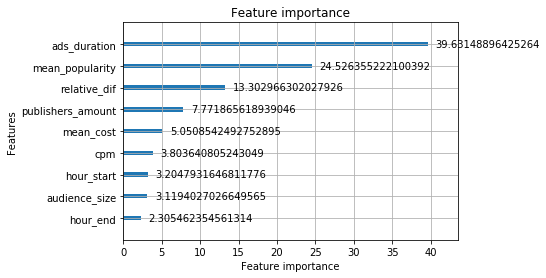

In [59]:
plot_importance(lgbm_model, importance_type ='gain')

In [199]:
%%time
# что-то тюнингом не пробивается 340 никак((
param_name = {'learning_rate': np.arange(0.05,1.0,0.05),'n_estimators': np.arange(1,15,1)}
search_scores = custom_search(X_lgbm, Y, lgbm_model, param_name)

Step 1/266
309.73749999999995 ± 21.323196963635635
Step 2/266
309.512 ± 21.279392049586377
Step 3/266
309.213 ± 21.2257160303251
Step 4/266
309.0515 ± 21.28462620648998
Step 5/266
308.72599999999994 ± 21.213485899304715
Step 6/266
308.48400000000004 ± 21.11677731094402
Step 7/266
308.2205 ± 21.06630686071955
Step 8/266
308.26649999999995 ± 21.103697608476104
Step 9/266
308.32399999999996 ± 21.111555461405494
Step 10/266
308.41600000000005 ± 21.197694308579884
Step 11/266
308.51249999999993 ± 21.230119141210686
Step 12/266
308.7915 ± 21.422735883868796
Step 13/266
309.0255000000001 ± 21.63574275937851
Step 14/266
309.27349999999996 ± 21.97012409500683
Step 15/266
309.45649999999995 ± 21.267165367062915
Step 16/266
308.927 ± 21.13505171510114
Step 17/266
308.48999999999995 ± 20.703887799155016
Step 18/266
308.3639999999999 ± 20.713209649882852
Step 19/266
308.2085 ± 20.889367217558316
Step 20/266
308.7584999999999 ± 21.13990734960775
Step 21/266
309.3639999999999 ± 21.55473460750561
Step

307.8075


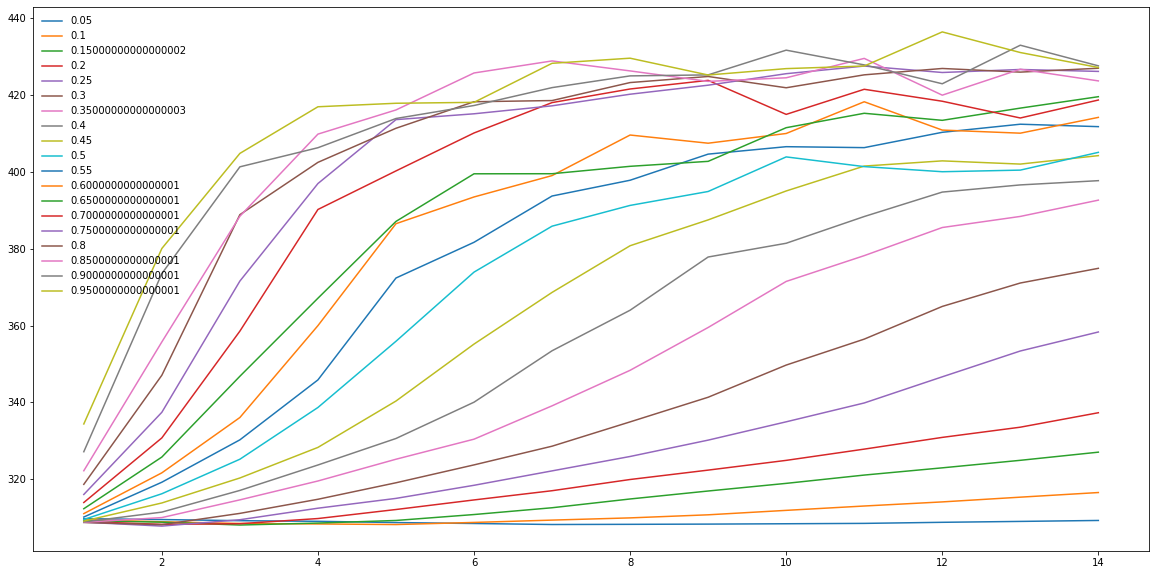

In [200]:
# проверялись параметры LGBM
# param_name = {'learning_rate': np.arange(0.05,1.0,0.05),'n_estimators': np.arange(1,15,1)}
fig, ax = plt.subplots(1,1)
fig.set_size_inches(20, 10)
for i in range(0,search_scores.shape[0]):
    plt.plot(list(param_name.values())[1],search_scores[i].T, label = list(param_name.values())[0][i])
ax.legend(loc='best', frameon=False)
print(np.min(search_scores))

# XGBoost

In [0]:
param_dict = {'learning_rate': 0.06}

In [0]:
# xgb_model = XGBRegressor(**param_dict)
xgb_model = XGBRegressor(verbosity=0)

In [0]:
X_xgb = X.copy()
X_xgb = X_xgb.drop(columns=['user_ids','publishers', 'discrepancy','at_least_one', 'at_least_two', 'at_least_three'])
# X_lgbm = X_lgbm[['publishers_amount', 'ads_duration', 'proba_discrepancy']]

In [72]:
X_xgb.head()

,cpm,hour_start,hour_end,audience_size,publishers_amount,ads_duration,proba_one,mean_cost,relative_dif,mean_popularity
0,220.0,1058,1153,1906,2,95,0.788306,201.954843,0.917977,40.567156
1,312.0,1295,1301,1380,2,6,0.885477,160.744132,0.515206,128.990580
2,70.0,1229,1249,888,6,20,0.302258,184.204108,2.631487,43.977477
3,240.0,1295,1377,440,2,82,0.816137,204.438568,0.851827,38.665909
4,262.0,752,990,1476,4,238,0.841761,219.125446,0.836357,35.524390


In [73]:
multilabel_model_cross_validation(X_xgb, Y, xgb_model)
# -----с абсолютной и относительной невязкой ставка/средняя цена ------
# без параметров 412.29499999999996 ± 45.777858130323224

409.7405 ± 42.1461692772902


[363.0,
 357.68,
 413.82,
 387.6,
 457.72,
 483.99,
 440.53,
 361.55,
 492.69,
 430.41,
 387.15,
 395.48,
 356.46,
 399.72,
 416.57,
 470.53,
 425.95,
 406.02,
 401.36,
 346.58]

In [74]:
%%time
param_name = {'subsample ': np.arange(0.1,0.6,0.1),'n_estimators': np.arange(10, 71, 5)}
search_scores = custom_search(X_xgb, Y, xgb_model, param_name)

Step 1/65
817.326 ± 93.76491920755862
Step 2/65
617.6595000000001 ± 64.58540713466161
Step 3/65
500.8974999999999 ± 47.7415667814746
Step 4/65
432.0735000000001 ± 37.61488791356423
Step 5/65
392.218 ± 33.587953137992805
Step 6/65
371.816 ± 33.235926104142195
Step 7/65
361.8945 ± 34.280833052159046
Step 8/65
364.15 ± 39.66706265908783
Step 9/65
368.606 ± 38.54577387989505
Step 10/65
380.675 ± 43.55945781343014
Step 11/65
387.58000000000004 ± 44.12918172819433
Step 12/65
393.58950000000004 ± 41.14235840043689
Step 13/65
396.3455 ± 41.97898789573184
Step 14/65
817.326 ± 93.76491920755862
Step 15/65
617.6595000000001 ± 64.58540713466161
Step 16/65
500.8974999999999 ± 47.7415667814746
Step 17/65
432.0735000000001 ± 37.61488791356423
Step 18/65
392.218 ± 33.587953137992805
Step 19/65
371.816 ± 33.235926104142195
Step 20/65
361.8945 ± 34.280833052159046
Step 21/65
364.15 ± 39.66706265908783
Step 22/65
368.606 ± 38.54577387989505
Step 23/65
380.675 ± 43.55945781343014
Step 24/65
387.5800000000

357.3985


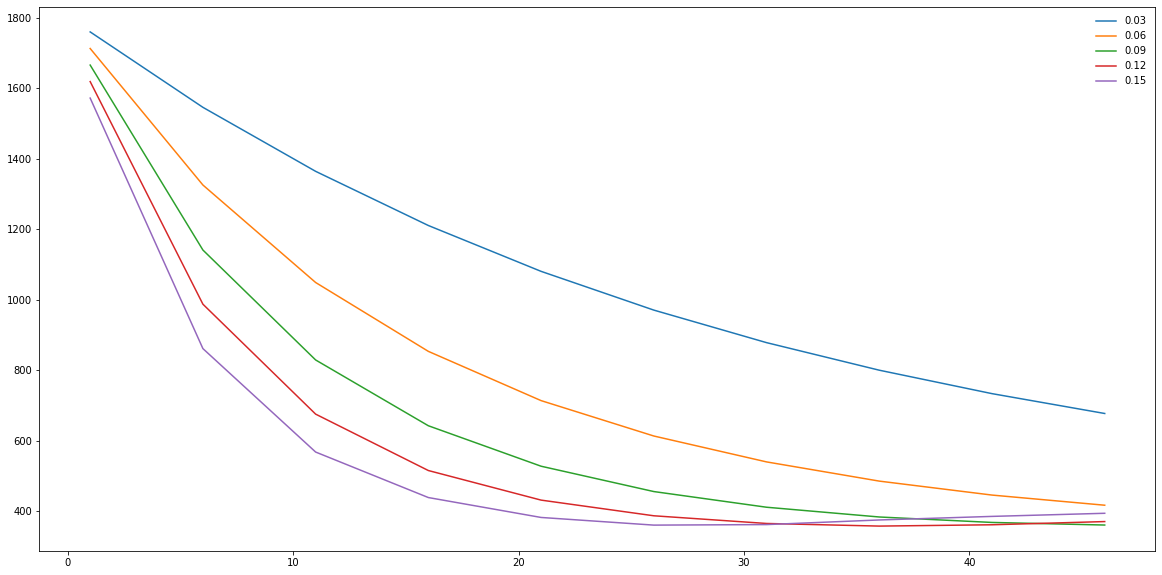

In [0]:
# проверялись параметры XGB
# param_name = {'learning_rate': np.arange(0.03,0.16,0.03),'n_estimators': np.arange(1, 151, 5)}
fig, ax = plt.subplots(1,1)
fig.set_size_inches(20, 10)
for i in range(0,search_scores.shape[0]):
    plt.plot(list(param_name.values())[1],search_scores[i].T, label = list(param_name.values())[0][i])
ax.legend(loc='best', frameon=False)
print(np.min(search_scores))

# Лог поисков параметров

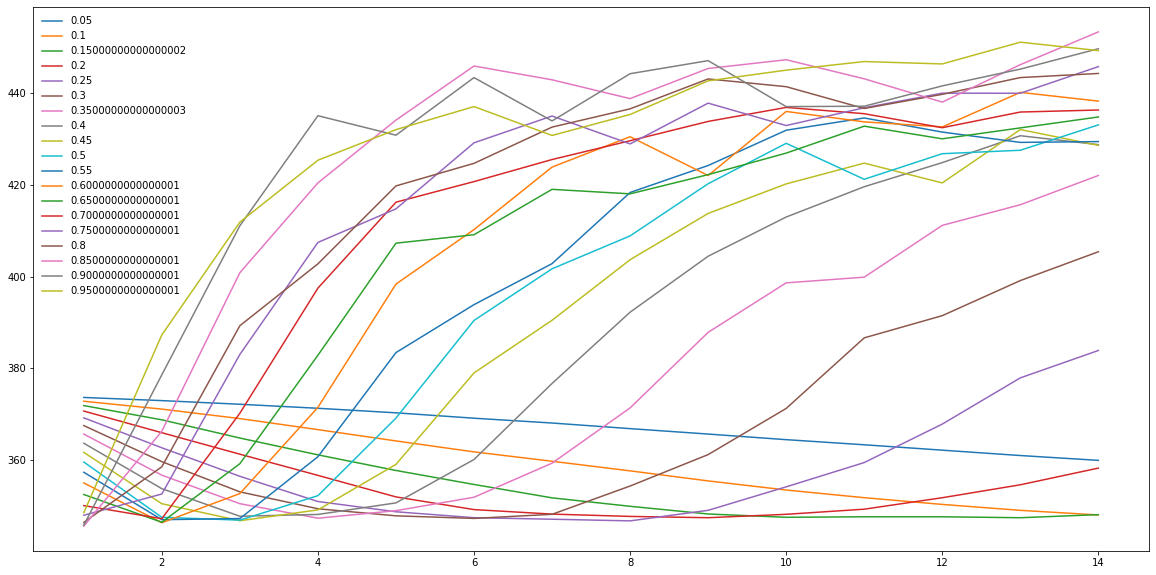

In [0]:
# проверялись параметры lGBM
# param_name = {'learning_rate': np.arange(0.05,1.0,0.05),'n_estimators': np.arange(1,15,1)}
fig, ax = plt.subplots(1,1)
fig.set_size_inches(20, 10)
for i in range(0,search_scores.shape[0]):
    plt.plot(list(param_name.values())[1],search_scores[i].T, label = list(param_name.values())[0][i])
ax.legend(loc='best', frameon=False)

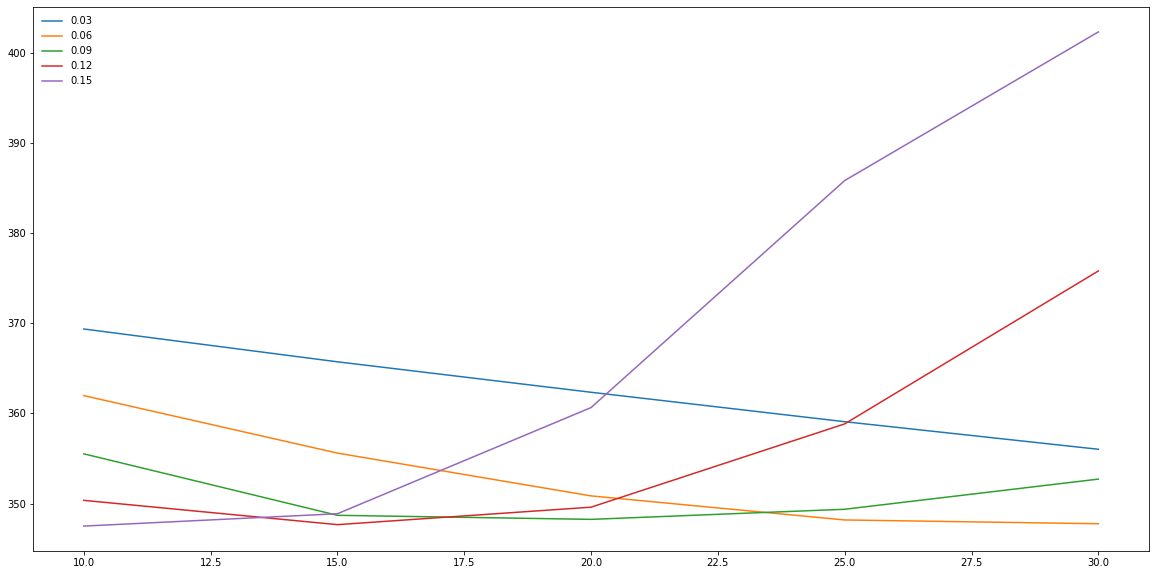

In [0]:
# проверялись параметры lGBM
# param_name = {'learning_rate': np.arange(0.03,0.16,0.03),'n_estimators': np.arange(10,31,5)}
fig, ax = plt.subplots(1,1)
fig.set_size_inches(20, 10)
for i in range(0,search_scores.shape[0]):
    plt.plot(list(param_name.values())[1],search_scores[i].T, label = list(param_name.values())[0][i])
ax.legend(loc='best', frameon=False)

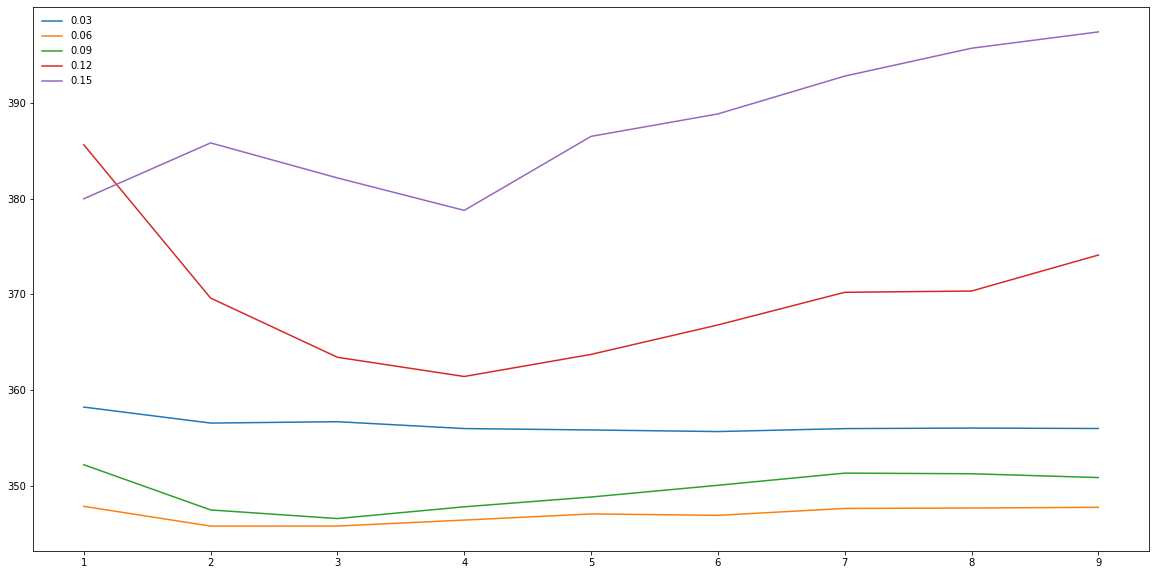

In [0]:
# проверялись параметры lGBM
# param_name = {'learning_rate': np.arange(0.03,0.16,0.03),'max_depth ': np.arange(1,10,1)}
fig, ax = plt.subplots(1,1)
fig.set_size_inches(20, 10)
for i in range(0,search_scores.shape[0]):
    plt.plot(list(param_name.values())[1],search_scores[i].T, label = list(param_name.values())[0][i])
ax.legend(loc='best', frameon=False)

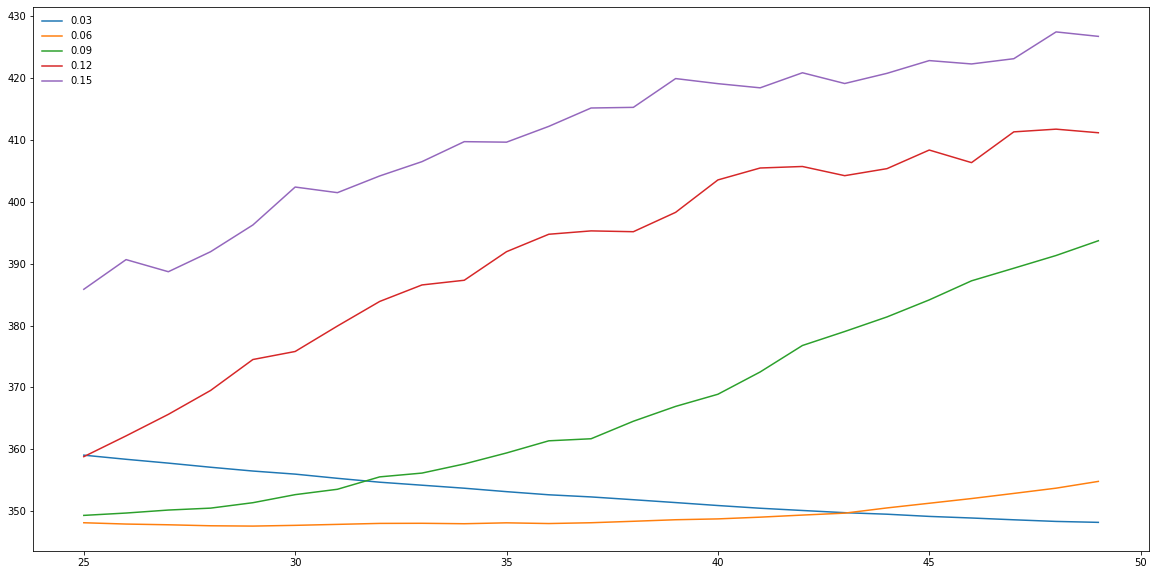

In [0]:
# проверялись параметры lGBM
# param_name = {'learning_rate': np.arange(0.03,0.16,0.03),'n_estimators': np.arange(25,50,1)}
fig, ax = plt.subplots(1,1)
fig.set_size_inches(20, 10)
for i in range(0,search_scores.shape[0]):
    plt.plot(list(param_name.values())[1],search_scores[i].T, label = list(param_name.values())[0][i])
ax.legend(loc='best', frameon=False)

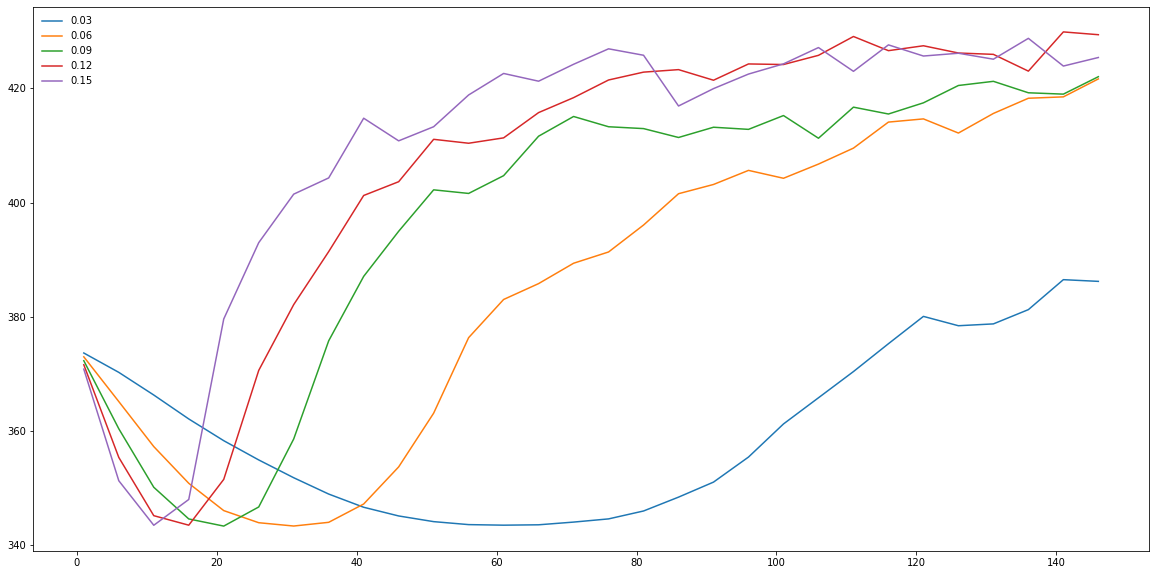

In [0]:
# проверялись параметры lGBM
# param_name = {'learning_rate': np.arange(0.03,0.16,0.03),'n_estimators': np.arange(1, 151, 5)}
fig, ax = plt.subplots(1,1)
fig.set_size_inches(20, 10)
for i in range(0,search_scores.shape[0]):
    plt.plot(list(param_name.values())[1],search_scores[i].T, label = list(param_name.values())[0][i])
ax.legend(loc='best', frameon=False)